In [1]:
import os
import time
from joblib import dump, load

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

data_path = "..\\data\\stackoverflow\\"
model_path = data_path + "models\\"
tb_path = os.path.join(model_path, "tb_logs")

np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = "{:,.2f}".format

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print("Tensorflow version: ", tf.__version__)
print("Tensorflow GPU detection: ", tf.config.list_physical_devices('GPU'))

Tensorflow version:  2.4.1
Tensorflow GPU detection:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def tb_logdir():
    current_time = time.strftime("mlp_%Y%m%d-%H%M%S")
    return os.path.join(tb_path, current_time)



In [3]:
y_dict = load(data_path + 'y_dict_top50.joblib')
title_vectorizer = load(model_path + 'title_vectorizer.joblib')
body_vectorizer = load(model_path + 'body_vectorizer_13.joblib')

In [4]:
title_corpus = load(data_path + 'title_corpus.joblib')
X_title = title_vectorizer.transform(title_corpus)

body_corpus = load(data_path + 'body_corpus.joblib')
X_body = body_vectorizer.fit_transform(body_corpus)



In [5]:
title_corpus[:10]

['determin smallest common divisor string',
 'use trait object contain method return refer self',
 'name function declar hoist put insid return statement',
 'get valu input caus flicker react',
 'assign vector atom type',
 'get first key object use docker inspect format get name network contain',
 'store choic vote count poll app array map',
 'packag cran import packag cran',
 'troubl get base r work',
 'sql subqueri use filter specif row']

In [6]:
body_vectorizer.vocabulary_['python']

2638

In [7]:
title_vectorizer.transform(['determin docker']).todense()[:,264]

matrix([[0.]])

In [8]:
df_tags = pd.read_pickle(data_path + 'Top_Tags.pkl')

mlb = MultiLabelBinarizer()
y_tags = mlb.fit_transform(df_tags['Tags_T50'])

In [9]:
np.where(mlb.classes_=="python")

(array([39], dtype=int64),)

In [10]:
y_tags[:,39][20:30]

array([1, 0, 0, 0, 1, 1, 0, 0, 1, 0])

In [11]:
y_dict['python'][20:30]

20    1
21    0
22    0
23    0
24    1
25    1
26    0
27    0
28    1
29    0
Name: Tags_T50, dtype: int64

In [12]:
y_python = y_tags[:,np.where(mlb.classes_=="python")[0][0]]

In [13]:
y_python[20:30]

array([1, 0, 0, 0, 1, 1, 0, 0, 1, 0])

In [14]:
X_title[:10,264].todense()

matrix([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [143]:
count = 50000
# X_train, X_test, y_train, y_test = train_test_split(X_title[:count].toarray(), y_tags[:count], random_state=42, test_size=0.2, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X_body[:count].toarray(), y_tags[:count], random_state=97, shuffle=True, test_size=0.2)
# X_train, X_test, y_train, y_test = train_test_split(X_body[:count].toarray(), y_tags[:count], shuffle=False, test_size=0.2)

In [144]:
embedding_dim = 8
model = keras.Sequential([
#     layers.Embedding(X_train.shape[1],16),
#     layers.Embedding(X_train.shape[1],128),
#     layers.LSTM(128),
#     layers.GlobalAveragePooling1D(),
#     layers.MaxPool1D(),
#     layers.Dense(X_train.shape[1], activation='relu'),
#     layers.Dense(embedding_dim, activation='relu'),
    layers.Dense(48, input_shape=(X_train.shape[1],), activation='relu',
#                  kernel_initializer="he_normal",
#                  kernel_regularizer=keras.regularizers.l1(0.000003)
                ),
#     layers.BatchNormalization(),
    layers.Dropout(.25),

    layers.Dense(48, activation='relu', 
#                  kernel_initializer="he_normal",
#                  kernel_regularizer=keras.regularizers.l1(0.000003)
                ),
    layers.Dropout(.25),
#     layers.Dense(32, activation='relu'),
#     layers.Dropout(.25),
#     layers.Dense(51, activation='softmax'),
    layers.Dense(51, activation='sigmoid'),
])

optimizer = keras.optimizers.Adam(lr=0.0003)
# optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(
    optimizer=optimizer,
#     optimizer="sgd",
    loss='binary_crossentropy',
#     loss='categorical_crossentropy',
#     loss='sparse_categorical_crossentropy',
#     loss='mse',
#     metrics=['accuracy'],
    metrics=['AUC'],
)
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 48)                192048    
_________________________________________________________________
dropout_44 (Dropout)         (None, 48)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 48)                2352      
_________________________________________________________________
dropout_45 (Dropout)         (None, 48)                0         
_________________________________________________________________
dense_71 (Dense)             (None, 51)                2499      
Total params: 196,899
Trainable params: 196,899
Non-trainable params: 0
_________________________________________________________________


In [145]:
tb_callback = keras.callbacks.TensorBoard(tb_logdir())
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=25,
    validation_data=(X_test, y_test),
#     validation_split=0.1,
    validation_steps=1,
    callbacks=[tb_callback],
)

Epoch 1/25
625/625 [==============================] - 4s 6ms/step - loss: 0.4070 - auc: 0.5329 - val_loss: 0.1106 - val_auc: 0.7767
Epoch 2/25
625/625 [==============================] - 3s 5ms/step - loss: 0.1257 - auc: 0.7021 - val_loss: 0.1074 - val_auc: 0.8097
Epoch 3/25
625/625 [==============================] - 3s 5ms/step - loss: 0.1195 - auc: 0.7426 - val_loss: 0.1020 - val_auc: 0.8504
Epoch 4/25
625/625 [==============================] - 3s 5ms/step - loss: 0.1112 - auc: 0.7954 - val_loss: 0.0949 - val_auc: 0.8885
Epoch 5/25
625/625 [==============================] - 3s 5ms/step - loss: 0.1039 - auc: 0.8382 - val_loss: 0.0889 - val_auc: 0.9138
Epoch 6/25
625/625 [==============================] - 3s 5ms/step - loss: 0.0974 - auc: 0.8697 - val_loss: 0.0844 - val_auc: 0.9273
Epoch 7/25
625/625 [==============================] - 3s 5ms/step - loss: 0.0924 - auc: 0.8905 - val_loss: 0.0808 - val_auc: 0.9306
Epoch 8/25
625/625 [==============================] - 3s 5ms/step - loss: 0.

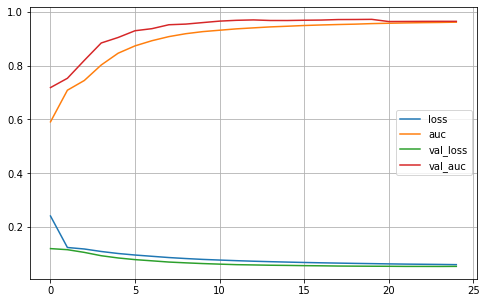

In [137]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
# plt.gca().set_ylim(0,1)
plt.show()

In [138]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0652 - auc: 0.9469


[0.06523797661066055, 0.946922779083252]

In [139]:
res = model.predict(X_test)

In [140]:
mlb.inverse_transform(y_test[1000:1010])

[('javascript', 'reactjs'),
 ('r',),
 ('other',),
 ('swiftui',),
 ('r',),
 ('powershell',),
 ('c',),
 ('ggplot2', 'r'),
 ('javascript',),
 ('python',)]

In [149]:
threshold = .25
tmp= pd.DataFrame(res[1000:1010]).applymap(lambda x:1 if x>threshold else 0)
mlb.inverse_transform(tmp.values)

[('javascript', 'reactjs'),
 ('r',),
 ('other',),
 ('ios', 'swift', 'swiftui'),
 ('r',),
 ('powershell',),
 (),
 ('python', 'r'),
 ('java', 'other'),
 ('other', 'python')]

[('android', 'firebase'),
 ('pandas', 'python'),
 ('javascript',),
 (),
 ('python',),
 ('javascript',)]

In [46]:
res[254:260].T

array([[0.41, 0.  , 0.01, 0.02, 0.  , 0.  ],
       [0.05, 0.  , 0.07, 0.06, 0.  , 0.11],
       [0.  , 0.  , 0.03, 0.01, 0.01, 0.03],
       [0.02, 0.  , 0.01, 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.01, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.01, 0.  ],
       [0.09, 0.  , 0.06, 0.06, 0.01, 0.03],
       [0.  , 0.  , 0.  , 0.  , 0.02, 0.01],
       [0.01, 0.  , 0.04, 0.06, 0.  , 0.02],
       [0.  , 0.3 , 0.  , 0.  , 0.03, 0.  ],
       [0.  , 0.02, 0.  , 0.  , 0.07, 0.  ],
       [0.  , 0.  , 0.  , 0.02, 0.  , 0.  ],
       [0.  , 0.02, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.01, 0.02, 0.  , 0.  ],
       [0.42, 0.  , 0.02, 0.01, 0.  , 0.01],
       [0.13, 0.  , 0.01, 0.02, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.01, 0.  , 0.  ],
       [0.01, 0.  , 0.1 , 0.15, 0.  , 0.04],
       [0.07, 0.  , 0.02, 0.01, 0.  , 0.01],
       [0.

In [38]:

mlb.inverse_transform(y_test[254:256])
# pd.DataFrame(res[254])

[('android', 'firebase'), ('dataframe', 'pandas', 'python')]

In [39]:
y_test[254:256]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]])

In [163]:
np.vstack((y_test[254], res[254])).T


array([[1.  , 0.46],
       [0.  , 0.01],
       [0.  , 0.  ],
       [0.  , 0.04],
       [0.  , 0.01],
       [0.  , 0.  ],
       [0.  , 0.  ],
       [0.  , 0.1 ],
       [0.  , 0.  ],
       [0.  , 0.  ],
       [0.  , 0.  ],
       [0.  , 0.  ],
       [0.  , 0.  ],
       [0.  , 0.  ],
       [0.  , 0.  ],
       [1.  , 0.44],
       [0.  , 0.18],
       [0.  , 0.  ],
       [0.  , 0.01],
       [0.  , 0.  ],
       [0.  , 0.  ],
       [0.  , 0.06],
       [0.  , 0.06],
       [0.  , 0.07],
       [0.  , 0.  ],
       [0.  , 0.  ],
       [0.  , 0.12],
       [0.  , 0.02],
       [0.  , 0.  ],
       [0.  , 0.02],
       [0.  , 0.  ],
       [0.  , 0.03],
       [0.  , 0.  ],
       [0.  , 0.  ],
       [0.  , 0.11],
       [0.  , 0.  ],
       [0.  , 0.03],
       [0.  , 0.01],
       [0.  , 0.01],
       [0.  , 0.  ],
       [0.  , 0.  ],
       [0.  , 0.  ],
       [0.  , 0.05],
       [0.  , 0.  ],
       [0.  , 0.  ],
       [0.  , 0.  ],
       [0.  , 0.  ],
       [0.  ,

In [47]:
res[39]

array([0.01, 0.  , 0.01, 0.  , 0.  , 0.  , 0.01, 0.05, 0.05, 0.01, 0.02,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ,
       0.04, 0.1 , 0.  , 0.01, 0.  , 0.  , 0.  , 0.01, 0.01, 0.01, 0.01,
       0.  , 0.15, 0.07, 0.01, 0.  , 0.  , 0.2 , 0.03, 0.08, 0.01, 0.01,
       0.02, 0.  , 0.  , 0.01, 0.  , 0.01, 0.  ], dtype=float32)

In [258]:
y_python[28]

1

In [377]:
res = model.predict(X_test[200:210])
for z in np.arange(res.shape[0]):
    classes = ""
    for r in np.arange(len(mlb.classes_)):
        if res[z][r]>.09:
            classes = classes + mlb.classes_[r] + ", "
    print("classe: ", classes )

ValueError: in user code:

    c:\users\vince\miniconda3\envs\tfml\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    c:\users\vince\miniconda3\envs\tfml\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\vince\miniconda3\envs\tfml\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\vince\miniconda3\envs\tfml\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\vince\miniconda3\envs\tfml\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\vince\miniconda3\envs\tfml\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    c:\users\vince\miniconda3\envs\tfml\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    c:\users\vince\miniconda3\envs\tfml\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\users\vince\miniconda3\envs\tfml\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:259 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer sequential_44 is incompatible with the layer: expected axis -1 of input shape to have value 1000 but received input with shape (None, 1)


In [267]:
df_tags[200:210]

,Tags_T100,Tags_T50,Tags_T10
200,[r],[r],[r]
201,[swift],[swift],[other]
202,"[c++, list]","[c++, list]",[c++]
203,[c#],[c#],[c#]
204,[c++],[c++],[c++]
205,[python],[python],[python]
206,"[flutter, dart]",[flutter],[other]
207,[python-3.x],[python-3.x],[python-3.x]
208,"[r, excel]","[r, excel]",[r]
209,"[python, tensorflow]",[python],[python]


In [301]:
body_corpus[200:210]

['happi new year everyon issu transform implicit miss data explicit miss data summar number observ bird specif survey site site survey month 12 month unfortun collect data contain inform actual observ bird rather also record bird observ site attempt add miss data extra observ ad data solut use complet fill miss data e site month survey bird observ abl fill miss site issu howev tri fill miss month extra observ ad site fact record observ bird specif addit observ ad station 9 march 1 2 bird april 1 2 bird result 32 total bird observ rather 30 bird exampl dataset code use mark code issu brand new tidyvers general piec advic improv code ear thank advanc help also includ phot correct number observ case',
 'follow sprite kit tutori notic use uiscreen main bound get extent screen work iphon size apart iphonex 11 wrote quick test shown move anchor point cgpoint x 0 0 place 3 label 20 40 60 point left edg work normal except iphonex number shift left wrong class gamescen skscene skphysicscontactd